<a href="https://colab.research.google.com/github/sishinami/usdjpy/blob/main/60%E5%88%86%E8%B6%B3%E3%81%A7%E6%AC%A1%E3%81%AE180%E5%88%86%E3%82%92%E4%BA%88%E6%B8%AC%E3%81%99%E3%82%8BLSTM_ALLDATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import pandas as pd

LSTM で 試してみるが、Ｌｏｓｓが少なすぎて怪しすぎる。原因調査が必要


In [2]:
save_model_name = 'drive/MyDrive/USDJPY/21-0413-alldata/'  # 保存しておくモデルの名前
EPOCH = 10      # 学習エポック
TRAIN_RATE = 0.9  # 全データ中の学習用データの割合 - 元データが多いので 0.9を学習に回す
BATCH_SIZE = 32 


In [3]:
df = pd.read_csv('drive/MyDrive/USDJPY/USDJPYmin.csv'
  ,header=None
  , names=['date','time','start','takane','yasune','end','dekidaka'])

In [4]:
# 標準化
y = np.array(df["end"].tolist())
sc = MinMaxScaler(feature_range=(0, 1)) 
y = y.reshape(-1, 1)
y = sc.fit_transform(y)

x = np.arange(len(y))

# 60分足で 次の180分後を予測する
input_len = 60

X, Y = [], []
for i, _ in enumerate(x):
    if (i+input_len+180 >= len(x)):
        break
    X.append(y[i:i+input_len])
    Y.append(y[i+input_len+180][0])

In [5]:
import pickle

with open('drive/MyDrive/USDJPY/MinMaxScaler.pickle', mode='wb') as f: 
    pickle.dump(sc, f)  



In [6]:

split_index = int(len(X)*TRAIN_RATE)
# 学習・テスト用データに分割 未来データを予測したいので 単純に先っぽの方をテストに回す
train_x = X[:split_index]
train_y = Y[:split_index]
test_x = X[split_index:]
test_y = Y[split_index:]

train_x = np.array(train_x).reshape(len(train_x), -1, 1)
test_x = np.array(test_x).reshape(len(test_x), -1, 1)
train_y = np.array(train_y).reshape(len(train_y))

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


NUM_DIM = 12  # 中間層の次元数 12の理由は特にない 適当 決め方誰か教えて

model = Sequential()
input_shape = (len(train_x[0]), 1)

# return_sequenceFalse 最後のRNN層のみが出力を返す
model.add(LSTM(NUM_DIM, input_shape=input_shape, return_sequences=False))
model.add(Dense(1, activation="linear"))  #全結合層 であってる？

model.compile(loss="mean_squared_error", optimizer="sgd")
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12)                672       
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCH, verbose=1)


Epoch 1/10
164199/164199 [==============================] - 664s 4ms/step - loss: 6.0204e-04
Epoch 2/10
164199/164199 [==============================] - 626s 4ms/step - loss: 2.1853e-05
Epoch 3/10
164199/164199 [==============================] - 624s 4ms/step - loss: 2.1758e-05
Epoch 4/10
164199/164199 [==============================] - 621s 4ms/step - loss: 2.1716e-05
Epoch 5/10
164199/164199 [==============================] - 620s 4ms/step - loss: 2.1688e-05
Epoch 6/10
164199/164199 [==============================] - 622s 4ms/step - loss: 2.1620e-05
Epoch 7/10
164199/164199 [==============================] - 619s 4ms/step - loss: 2.1595e-05
Epoch 8/10
164199/164199 [==============================] - 620s 4ms/step - loss: 2.1638e-05
Epoch 9/10
164199/164199 [==============================] - 633s 4ms/step - loss: 2.1630e-05
Epoch 10/10
164199/164199 [==============================] - 635s 4ms/step - loss: 2.1561e-05


In [9]:
score = model.evaluate(test_x, np.array(test_y))


18245/18245 [==============================] - 47s 3ms/step - loss: 1.2285e-05


In [10]:
# train loss: 学習データに対する損失関数の値
# → この値が小さくなると、学習ができている。
# train accuracy: 学習データに対する分類の正答率
# → 損失関数が小さいということは分類精度が高いということなので、「loss が下がるほど、accuracy が上がる」という関係
# test loss: テストデータに対する損失関数の値
# → この値が小さくなると、汎化性能が出ている。
# test accuracy: テストデータに対する分類の正答率
print(score)
#1.822907324822154e-05  ほんとかよ？

1.2285098819120321e-05


In [11]:
predict_y = model.predict(test_x)   # 予測値の抽出
predict_y = sc.inverse_transform(predict_y)     # 元の値に戻す

In [12]:
model.save(save_model_name)

INFO:tensorflow:Assets written to: drive/MyDrive/USDJPY/21-0413-alldata/assets


INFO:tensorflow:Assets written to: drive/MyDrive/USDJPY/21-0413-alldata/assets


ここから下は図にするところです

In [13]:
df['datetime'] = df['date'] + ' ' + df['time']

In [14]:
label_x = df["datetime"].apply(lambda x: datetime.strptime(x, "%Y.%m.%d %H:%M"))

In [15]:
new_format = "%Y-%m-%dT%H:%M"
label_x = label_x.apply(lambda x: x.strftime(new_format)).tolist()
label_x = label_x[len(y)-len(test_y):]

test_y = sc.inverse_transform(np.array(test_y).reshape(-1,1))
test_y = test_y.reshape(len(test_y))

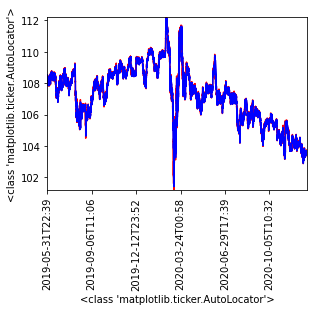

In [16]:
import matplotlib as mpl

fig = plt.figure()
ax = fig.add_axes((0.2, 0.2, 0.6, 0.6))

ax.plot(label_x, test_y, color = "red")
ax.plot(label_x, predict_y, color = "blue")

ax.xaxis.set_major_locator(mpl.ticker.AutoLocator())
ax.yaxis.set_major_locator(mpl.ticker.AutoLocator())

ax.set(xlim=(min(label_x),max(label_x)), ylim=(min(test_y), max(test_y)))
plt.xticks(rotation=90)

ax.set(xlabel=type(ax.xaxis.get_major_locator()),
       ylabel=type(ax.yaxis.get_major_locator()))

plt.show()